# Hertz-Mindlin vs Walton models

Ref: Pride, S. R. (2005). Relationships between seismic and hydrological properties. In *Hydrogeophysics* (pp. 253-290). Springer, Dordrecht.

- [Load packages and routines](#load_packages)
- [Plotting parameters](#plot_param)
- [Input parameters](#input_param)
- [Analytical comparison of the models](#analytical_comparison)
- [Numerical comparison of the models](#numerical_comparison)
- [Correction of Walton's model for low stresses (Pride, 2005)](#pride_correction)

<a id=load_packages></a>
### Load packages and routines

In [1]:
import os
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

In [2]:
# Go to Python folder to import routines
if os.getcwd() != 'C:\\Olivia\\Python': 
    os.chdir('C:\\Olivia\\Python')
print('Current directory: ', os.getcwd())
print('Python folders: ', [x for x in os.listdir() if '.' not in x])

Current directory:  C:\Olivia\Python
Python folders:  ['EffectiveMedia', 'Fluid', 'Hydro', 'LabProcessing', 'Stress', 'Thermal', 'Utils']


In [3]:
# Import routines
from EffectiveMedia.GranularModels import HertzMindlin, Walton, Walton_modified
#from Fluid.Gassmann import isoGassmann, fluidWood
#from Hydro.hydro_models import Swe_from_wt_VG
#from Utils.bounds import HillAvr
#from Utils.elastic_param import Vp_from_K_G, Vs_from_G

<a id=plot_param></a>
### Plotting parameters

In [4]:
# Plot parameters
plt.rc('axes',labelsize=16)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)

<a id=input_param></a>
### Input parameters

In [5]:
# Mineral properties (assuming monomineralic and made of Quartz)
Ks = 45     #GPa
Gs = 36     #GPa 
rho_s = 2.6  #g/cc
f_Qz = 1.0    #unitless

# Rock matrix properties
phi = 0.40  #Porosity - measured (see Barriere et al., GJI 2012)
C = 9       #Coordination number - (Barriere et al., GJI 2012)

# Additional parameters for Walton (1987) model
P0 = 18     #Critical effective pressure (MPa) - (Barriere et al., GJI 2012)

# Additional parameters for Hertz-Mindlin model
FC = 1

<a id=analytical_comparison></a>
### Analytical comparison of the models

Define symbols : 

In [6]:
K_s, G_s, P_e, phi_0, n, f = smp.symbols('K_s G_s P_e phi_0 n f', real=True, positive=True)

Walton model : 

In [7]:
C_s = (1/(4*smp.pi))*(1/G_s + 1/(K_s+G_s/3))
Kd_Walton = smp.Rational(1,6)*(3*(1-phi_0)**2*n**2*P_e/(smp.pi**4*C_s**2))**smp.Rational(1,3)

In [41]:
Kd_Walton

6**(1/3)*P_e**(1/3)*n**(2/3)*Abs(phi_0 - 1)**(2/3)/(3*pi**(2/3)*(1/(G_s/3 + K_s) + 1/G_s)**(2/3))

In [8]:
smp.simplify(Kd_Walton)

6**(1/3)*G_s**(2/3)*P_e**(1/3)*n**(2/3)*(G_s + 3*K_s)**(2/3)*Abs(phi_0 - 1)**(2/3)/(3*pi**(2/3)*(4*G_s + 3*K_s)**(2/3))

Hertz-Mindlin model : 

In [9]:
PRm = (smp.Rational(3,2)*K_s-G_s)/(3*K_s+G_s)
chi = n*(1-phi_0)*G_s/(smp.pi*(1-PRm))
chi2 = chi*chi
Kd_HM = ( (chi2*P_e) / 18 ) ** smp.Rational(1,3)

In [10]:
smp.simplify(Kd_HM)

6**(1/3)*G_s**(2/3)*P_e**(1/3)*n**(2/3)*(G_s + 3*K_s)**(2/3)*Abs((phi_0 - 1)**(2/3))/(3*pi**(2/3)*(4*G_s + 3*K_s)**(2/3))

<a id=numerical_comparison></a>
### Numerical comparison of the models

In [11]:
Peff = np.linspace(0,50,100) #Effective pressure (MPa)

#### Assuming smooth grains, i.e. tangential slip always occurs between the grains
In that case, $R=3/5$ in Walton's model and $FC=0$ in Hertz-Mindlin's model.

In [12]:
Kdr_HM_low, Gdr_HM_low = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=0) 
Kdr_Walton_low, Gdr_Walton_low = Walton(Ks, Gs, Peff, C=C, phi=phi, R=3/5)

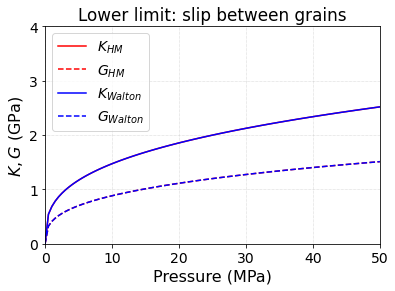

In [19]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

ax.plot(Peff, Kdr_HM_low, 'r', label='$K_{HM}$')
ax.plot(Peff, Gdr_HM_low, 'r--', label='$G_{HM}$')
ax.plot(Peff, Kdr_Walton_low, 'b', label='$K_{Walton}$')
ax.plot(Peff, Gdr_Walton_low, 'b--', label='$G_{Walton}$')
ax.set(xlabel = 'Pressure (MPa)', xlim=[0,50],
       ylabel = '$K, G$ (GPa)', ylim=[0,4],
       title='Lower limit: slip between grains')
ax.legend()
ax.grid()
plt.show()

#### Assuming rough grains, i.e. no slip occurs between the grains
In that case, $R=\frac{18}{5}\frac{K_s+G_s}{3K_s+2G_s}$ in Walton's model and $FC=1$ in Hertz-Mindlin's model.


In [20]:
Kdr_HM_up, Gdr_HM_up = HertzMindlin(Ks, Gs, Peff, phi=phi, C=C, FC=1) 
Kdr_Walton_up, Gdr_Walton_up = Walton(Ks, Gs, Peff, phi=phi, C=C, R=(18/5)*(Ks+Gs)/(3*Ks+2*Gs))

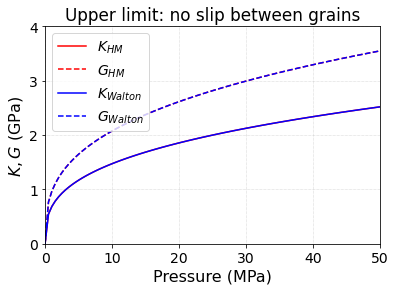

In [21]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

ax.plot(Peff, Kdr_HM_up, 'r', label='$K_{HM}$')
ax.plot(Peff, Gdr_HM_up, 'r--', label='$G_{HM}$')
ax.plot(Peff, Kdr_Walton_up, 'b', label='$K_{Walton}$')
ax.plot(Peff, Gdr_Walton_up, 'b--', label='$G_{Walton}$')
ax.set(xlabel = 'Pressure (MPa)', xlim=[0,50],
       ylabel = '$K, G$ (GPa)', ylim=[0,4],
       title='Upper limit: no slip between grains')
ax.legend(loc='upper left')
ax.grid()
plt.show()

<a id=pride_correction></a>
### Correction of Walton's model for low stresses (Pride, 2005)

"Data on natural sands (e.g., Hardin and Richart, 1963; Domenico, 1977) indicate that both $G$ and $K_D$ increase with effective stress as $P_e^{1/2}$ for $0<P_e<P_0$, where $P_0$ is observed to be on the order of 10 MPa (correponding to a depth of roughly 1km). For $P_e>P_0$, both $G$ and $K_D$ roll over to a more gradual $P_e^{1/3}$ increase." *(Pride, 2005)*

Walton's model is valid for $P_e>P_0$, but does not account for the negative dilatation that occurs at lower stresses. This can be accounted for by modifying the coordination number for lower stresses. Walton's model can be expressed as :
\begin{equation}
K_D = \dfrac{1}{6} \left[\dfrac{4(1-\phi_0)^2n_0^2P_0}{\pi^4C_s^2}\right]^\frac{1}{3} \left[1+\left(\frac{16P_e}{9P_0}\right)^4\right]^{-\frac{1}{24}} \left[\dfrac{P_e}{P_0}\right]^\frac{1}{2} 
\end{equation}
where $P_0$ is the pressure beyond which $n=n_0$, and $n_0$ is the number of contacts per grain in the high-stress limit (this number remains constant for $P_e>P_0$).

In [30]:
Peff = np.linspace(0,20,100)*1e-3 #Effective pressure (MPa)
P0 = 18 #Critical pressure (MPa) - (Barriere et al., GJI 2012)
C0 = 9  #High-stress limit coordination number - (Barriere et al., GJI 2012)

Kdr_Walton_mod, Gdr_Walton_mod = Walton_modified(Ks, Gs, Peff, P0, 
                                                 phi=phi, C0=C0, R=3/5)

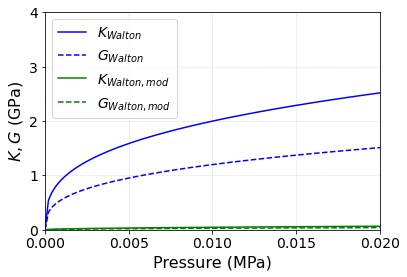

In [40]:
fig = plt.figure(figsize=(6,4))
ax = plt.axes()

ax.plot(Peff, Kdr_Walton_low, 'b', label='$K_{Walton}$')
ax.plot(Peff, Gdr_Walton_low, 'b--', label='$G_{Walton}$')
ax.plot(Peff, Kdr_Walton_mod, 'g', label='$K_{Walton,mod}$')
ax.plot(Peff, Gdr_Walton_mod, 'g--', label='$G_{Walton,mod}$')
ax.set(xlabel = 'Pressure (MPa)', xlim=[0,20*1e-3],
       ylabel = '$K, G$ (GPa)', ylim=[0,4])
ax.legend()
ax.grid()
plt.show()